# Demo of Information-Theoretic Diffusion
Using code adapted from https://github.com/gregversteeg/InfoDiffusionSimple 

### Imports and installation

In [42]:
import numpy as np 
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import math
import os
import argparse
import tqdm, time
from tqdm import trange

In [2]:
!pip install diffusers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install pytorch-lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
from diffusers import UNet2DModel

In [5]:
import pytorch_lightning as pl
from torch.utils.data import DataLoader
from pytorch_lightning.callbacks import Callback

## Datasets

In [6]:
"""
Nice 2-d examples from: https://github.com/tanelp/tiny-diffusion
Standardizing the data, scale to have unit variance, as we do here. helps with interpretability,
as discussed in "Information-theoretic diffusion". The gap between MMSE and gaussian MMSE should be non-negative
and log likelihood can be interpreted as a stochastic lower bound on the true log likelihood.
"""

from sklearn.datasets import make_moons
from torch.utils.data import TensorDataset
import pandas as pd

def scg(n=20000):
    """Strongly correlated Gaussian"""
    # Load synthetic dataset, visualize and make dataloader
    cov = torch.tensor([[1., -0.4950 / 0.5050], [-0.4950 / 0.5050, 1.]])
    mu = torch.zeros(2)
    q_d = torch.distributions.multivariate_normal.MultivariateNormal(mu, cov)
    # TODO: Can use "transformed distributions" to do more complex distributions - pyro or flowtorch?
    print("True entropy of this Gaussian distribution is:", q_d.entropy())
    return TensorDataset(q_d.sample((n,)))


def moons_dataset(n=8000):
    X, _ = make_moons(n_samples=n, random_state=42, noise=0.03)
    X[:, 0] = (X[:, 0] + 0.3) * 2 - 1
    X[:, 1] = (X[:, 1] + 0.3) * 3 - 1
    X -= X.mean(axis=0)
    X /= X.std(axis=0)
    return TensorDataset(torch.from_numpy(X.astype(np.float32)))


def line_dataset(n=8000):
    # This ends up looking like a square because we standardize the data
    rng = np.random.default_rng(42)
    x = rng.uniform(-0.5, 0.5, n)
    y = rng.uniform(-1, 1, n)
    X = np.stack((x, y), axis=1)
    X -= X.mean(axis=0)
    X /= X.std(axis=0)
    return TensorDataset(torch.from_numpy(X.astype(np.float32)))


def circle_dataset(n=8000):
    rng = np.random.default_rng(42)
    x = np.round(rng.uniform(-0.5, 0.5, n)/2, 1)*2
    y = np.round(rng.uniform(-0.5, 0.5, n)/2, 1)*2
    norm = np.sqrt(x**2 + y**2) + 1e-10
    x /= norm
    y /= norm
    theta = 2 * np.pi * rng.uniform(0, 1, n)
    r = rng.uniform(0, 0.03, n)
    x += r * np.cos(theta)
    y += r * np.sin(theta)
    X = np.stack((x, y), axis=1)
    X -= X.mean(axis=0)
    X /= X.std(axis=0)
    return TensorDataset(torch.from_numpy(X.astype(np.float32)))


def dino_dataset(n=8000):
    # df = pd.read_csv("assets/DatasaurusDozen.tsv", sep="\t")
    url_DatasaurusDozen = "https://raw.githubusercontent.com/gregversteeg/InfoDiffusionSimple/master/assets/DatasaurusDozen.tsv"
    df = pd.read_csv(url_DatasaurusDozen, sep="\t")
    df = df[df["dataset"] == "dino"]

    rng = np.random.default_rng(42)
    ix = rng.integers(0, len(df), n)
    x = df["x"].iloc[ix].tolist()
    x = np.array(x) + rng.normal(size=len(x)) * 0.15
    y = df["y"].iloc[ix].tolist()
    y = np.array(y) + rng.normal(size=len(x)) * 0.15
    x = (x/54 - 1) * 4
    y = (y/48 - 1) * 4
    X = np.stack((x, y), axis=1)
    X -= X.mean(axis=0)
    X /= X.std(axis=0)
    return TensorDataset(torch.from_numpy(X.astype(np.float32)))

def two_spirals(n_samples=8000):
    z = torch.randn(n_samples, 2)
    n = torch.sqrt(torch.rand(n_samples // 2)) * 540 * (2 * math.pi) / 360
    d1x = - torch.cos(n) * n + torch.rand(n_samples // 2) * 0.5
    d1y =   torch.sin(n) * n + torch.rand(n_samples // 2) * 0.5
    x = torch.cat([torch.stack([ d1x,  d1y], dim=1),
                    torch.stack([-d1x, -d1y], dim=1)], dim=0) / 3
    return x + 0.1*z

def get_dataset(name, n=8000):
    if name == "moons":
        return moons_dataset(n)
    elif name == "dino":
        return dino_dataset(n)
    elif name == "line":
        return line_dataset(n)
    elif name == "circle":
        return circle_dataset(n)
    elif name == "scg":
        return scg(n)
    elif name == "two_spirals":
        return two_spirals(n)
    else:
        raise ValueError(f"Unknown dataset: {name}")

## Model Components

In [7]:
class MLP(nn.Module):
    def __init__(self, in_dim, hidden_dim, n_layers, activation=nn.ReLU, dropout=0., emb_size=128, embedding=True):
        super().__init__()
        self.embedding = embedding
        self.in_dim = in_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.activation = activation
        self.dropout = dropout

        self.layers = nn.ModuleList()
        self.time_mlp = SinusoidalEmbedding(emb_size, scale=50.)  # "time" embedding in prev work is 1-1000. Ours is logsnr, ~(-5, 10)
        self.input_mlp1 = SinusoidalEmbedding(emb_size, scale=100.)
        self.input_mlp2 = SinusoidalEmbedding(emb_size, scale=100.)

        if self.embedding:
            self.layers.append(nn.Linear((in_dim + 1) * emb_size, hidden_dim))  # Concatenate, after embeddings
        else:
            self.layers.append(nn.Linear(in_dim + 1, hidden_dim))  # Concatenate logsnr with input, no embedding
        self.layers.append(activation())
        if dropout > 0:
            self.layers.append(nn.Dropout(dropout))
        for _ in range(n_layers - 2):
            self.layers.append(nn.Linear(hidden_dim, hidden_dim))
            self.layers.append(activation())
            if dropout > 0:
                self.layers.append(nn.Dropout(dropout))
        self.layers.append(nn.Linear(hidden_dim, in_dim))

    def forward(self, x, logsnr):
        if self.embedding:
            x1_emb = self.input_mlp1(x[:, 0])
            x2_emb = self.input_mlp2(x[:, 1])
            t_emb = self.time_mlp(logsnr)
            x = torch.cat((x1_emb, x2_emb, t_emb), dim=-1)
        else:
            x = torch.concat((x, logsnr.unsqueeze(1)), dim=1)  # concatenate logsnr
        for layer in self.layers:
            x = layer(x)
        return x

# TODO: input embeddings were super useful in https://github.com/tanelp/tiny-diffusion/blob/master/positional_embeddings.py
# Time embeddings were not as important.
class SinusoidalEmbedding(nn.Module):
    def __init__(self, size: int, scale: float = 1.0):
        super().__init__()
        self.size = size
        self.scale = scale

    def forward(self, x):
        x = x * self.scale
        half_size = self.size // 2
        emb = torch.log (torch.Tensor([10000.0]).to(x.device)) / (half_size - 1)
        emb = torch.exp(-emb * torch.arange(half_size, device=x.device))
        emb = x.unsqueeze(-1) * emb.unsqueeze(0)
        emb = torch.cat( (torch.sin(emb), torch.cos(emb)), dim=-1)
        return emb

    def __len__(self):
        return self.size


class WrapUNet2DModel(UNet2DModel):
    """Wrap UNet2DModel to accept arguments compatible with Diffusion Model."""
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def forward(self, x, logsnr):
        timestep = self.logsnr2t(logsnr)
        eps_hat = super().forward(x, timestep)["sample"]
        return eps_hat

    def logsnr2t(self, logsnr):
        num_diffusion_steps = 10000  # improve the timestep precision
        alphas_cumprod = torch.sigmoid(logsnr)
        scale = 1000 / num_diffusion_steps
        beta_start = scale * 0.0001
        beta_end = scale * 0.02
        betas = np.linspace(beta_start, beta_end, num_diffusion_steps, dtype=np.float64)
        alphas = 1.0 - betas
        alphabarGT = torch.tensor(np.cumprod(alphas, axis=0), device=logsnr.device, dtype=logsnr.dtype)
        timestep = torch.argmin(abs(alphabarGT-alphas_cumprod.unsqueeze(-1)), dim=1) * scale
        return timestep


## Model

In [8]:
"""
Main information theoretic diffusion model class, with optional contrastive loss. See readme.md.
"""

class DiffusionModel(pl.LightningModule):
    def __init__(self, denoiser, x_shape=(2,),
                 learning_rate=0.001,
                 logsnr_loc=2., logsnr_scale=3.):  # Log SNR importance sampling distribution parameters
        super().__init__()
        self.save_hyperparameters(ignore=["denoiser"])  # saves full argument dict into self.hparams
        self.model = denoiser  # First argument of "model" is data, second is log SNR (per sample)
        self.d = np.prod(x_shape)  # Total dimensionality
        self.h_g = 0.5 * self.d * math.log(2 * math.pi * math.e)  # Differential entropy for N(0,I)
        self.left = (-1,) + (1,) * (len(x_shape))  # View for left multiplying a batch of samples

    def forward(self, x, logsnr):
        return self.model(x, logsnr)

    def training_step(self, batch, batch_idx):
        loss = self.nll(batch)
        self.log("train_loss", loss)
        return loss

    def noisy_channel(self, x, logsnr):
        """Add Gaussian noise to x, return "z" and epsilon."""
        logsnr = logsnr.view(self.left)  # View for left multiplying
        eps = torch.randn((len(logsnr),) + self.hparams.x_shape, device=self.device)
        return torch.sqrt (torch.sigmoid(logsnr)) * x + torch.sqrt (torch.sigmoid(-logsnr)) * eps, eps

    def mse(self, x, logsnr):
        """MSE for recovering epsilon from noisy channel, for given log SNR values."""
        z, eps = self.noisy_channel(x, logsnr)
        eps_hat = self(z, logsnr)
        error = (eps - eps_hat).flatten(start_dim=1)
        return torch.einsum('ij,ij->i', error, error)  # MSE of epsilon estimate, per sample

    def nll(self, batch):
        """Estimate of negative log likelihood for a batch, - E_x [log p(x)], the data distribution."""
        x = batch[0]
        logsnr, weights = logistic_integrate(len(x), self.hparams.logsnr_loc, self.hparams.logsnr_scale,
                                             device=self.device)  # use same device as LightningModule
        mses = self.mse(x, logsnr)
        mmse_gap = mses - self.d * torch.sigmoid(logsnr)  # MSE gap compared to using optimal denoiser for N(0,I)
        return self.h_g + 0.5 * (weights * mmse_gap).mean()  # Interpretable as differential entropy (nats)

    def nll_x(self, x, npoints=200):
        """-log p(x) for a single sample, x"""
        return self.nll([x.unsqueeze(0).expand((npoints,) + self.hparams.x_shape)])

    def score(self, x, alpha):
        """\nabla_z \log p_\alpha(z), converges to data dist. score in large SNR limit."""
        return -self.model(x, alpha) / torch.sqrt (torch.sigmoid(-alpha.view(self.left)))

    def configure_optimizers(self):
        """Pytorch Lightning optimizer hook."""
        return torch.optim.Adam(self.parameters(), lr=self.hparams.learning_rate)

    def validation_step(self, batch, batch_idx, nrepeat=1):
        with torch.no_grad():
            loss = 0.
            for i in range(nrepeat):
                loss += self.nll(batch) / nrepeat
        self.log("val_loss", loss)
        if batch_idx == 0:  # Plot and log MSE curve, for one batch per epoch
            mses = []
            loc, s = self.hparams.logsnr_loc, self.hparams.logsnr_scale
            x = batch[0]
            logsnrs = torch.linspace(loc - 4 * s, loc + 4 * s, 100, device=self.device)
            mmse_g = self.d * torch.sigmoid(logsnrs)
            for logsnr in logsnrs:
                mses.append(self.mse(x, torch.ones(len(x), device=self.device) * logsnr).mean().cpu())
            tb = self.logger.experiment  # tensorboard logger
            fig, ax = plt.subplots(1, 1)
            ax.plot(logsnrs.cpu(), mses, label="MSE")
            ax.plot(logsnrs.cpu(), mmse_g.cpu(), label='MMSE Gaussian')
            ax.set_ylabel('$E[(\epsilon - \hat \epsilon)^2]$')
            ax.set_xlabel('log SNR ($\\alpha$)')
            ax.legend()

            tb.add_figure('mses', figure=fig, global_step=self.current_epoch)
        return loss


def logistic_integrate(npoints, loc, scale, clip=4., device='cpu'):
    """Return sample point and weights for integration, using
    a truncated logistic distribution as the base, and importance weights.
    """
    loc, scale, clip = torch.tensor(loc, device=device), torch.tensor(scale, device=device), torch.tensor(clip, device=device)
    # IID samples from uniform, use inverse CDF to transform to target distribution
    ps = torch.rand(npoints, device=device)
    ps = torch.sigmoid(-clip) +  (torch.sigmoid(clip) - torch.sigmoid(-clip)) * ps  # Scale quantiles to clip
    logsnr = loc + scale *  (torch.log(ps) - torch.log(1-ps))  # Using quantile function for logistic distribution

    # importance weights
    weights = scale * torch.tanh(clip / 2) /  (torch.sigmoid((logsnr - loc)/scale) * torch.sigmoid(-(logsnr - loc)/scale))
    return logsnr, weights


## Training

### Configure parameters

In [16]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device = "mps" if torch.backends.mps.is_available() else device  # For M1/M2 Macs

In [17]:
parser = argparse.ArgumentParser()
parser.add_argument("--experiment_name", type=str, default="base")
parser.add_argument("--dataset", type=str, default="moons", choices=["circle", "dino", "line", "moons", "scg", "two_spirals"])
parser.add_argument("--train_batch_size", type=int, default=128)
parser.add_argument("--eval_batch_size", type=int, default=1024)
parser.add_argument("--num_epochs", type=int, default=160)
parser.add_argument("--learning_rate", type=float, default=1e-3)
parser.add_argument("--logsnr_loc", type=float, default=0.)  # lognsr location and scale parameters
parser.add_argument("--logsnr_scale", type=float, default=3.)  # lognsr location and scale parameters
parser.add_argument("--embedding_size", type=int, default=128)
parser.add_argument("--hidden_size", type=int, default=128)
parser.add_argument("--hidden_layers", type=int, default=3)
parser.add_argument("--embedding", type=bool, default=True, help="Use sinusoidal embedding for input and snr/time")

_StoreAction(option_strings=['--embedding'], dest='embedding', nargs=None, const=None, default=True, type=<class 'bool'>, choices=None, required=False, help='Use sinusoidal embedding for input and snr/time', metavar=None)

In [18]:
config = parser.parse_args("")

### Training setup

In [19]:
# config.num_epochs = 20 # just a quick thing for prototyping
# config.dataset = "two_spirals"

In [20]:
config.__dict__

{'experiment_name': 'base',
 'dataset': 'moons',
 'train_batch_size': 128,
 'eval_batch_size': 1024,
 'num_epochs': 160,
 'learning_rate': 0.001,
 'logsnr_loc': 0.0,
 'logsnr_scale': 3.0,
 'embedding_size': 128,
 'hidden_size': 128,
 'hidden_layers': 3,
 'embedding': True}

In [21]:
outdir = f"exps/{config.dataset}-{config.experiment_name}"
os.makedirs(outdir, exist_ok=True)
imgdir = f"assets"
os.makedirs(imgdir, exist_ok=True)

# Data
dataset = get_dataset(config.dataset)
n = len(dataset)
train, val = torch.utils.data.random_split(dataset, [int(0.9*n), n - int(0.9*n)])
train_dl = DataLoader(train, batch_size=config.train_batch_size, shuffle=True, drop_last=True)
val_dl = DataLoader(val, batch_size=(n - int(0.9*n)), shuffle=False, drop_last=False)  # one giant batch

# Model
denoiser = MLP(in_dim=2,
                    hidden_dim=config.hidden_size,
                    n_layers=config.hidden_layers)
model = DiffusionModel(denoiser,
                    x_shape=(2,),
                    learning_rate=config.learning_rate,
                    logsnr_loc=config.logsnr_loc, logsnr_scale=config.logsnr_scale)

# Train
x_sample = dataset.tensors[0].numpy()
random_rows = np.random.choice(len(x_sample), min(200, len(x_sample)), replace=False)
x_sample = x_sample[random_rows]

class MyCallback(Callback):
    val_loop_count = 0
    save_grid = []
    grid_x, grid_y = None, None

    def __init__(self, show=False):
        super().__init__()
        self.show = show

    def on_train_epoch_end(self, trainer, pl_module):
        # Save contour plot info
        c = 3.
        x_min, x_max, y_min, y_max, r = -c, c, -c, c, 40
        grid_x, grid_y = torch.meshgrid(torch.linspace(x_min, x_max, r), torch.linspace(y_min, y_max, r), indexing='ij')
        xs = torch.stack([grid_x.flatten(), grid_y.flatten()]).T
        xs = xs.to(device)
        with torch.no_grad():
            nll_grid = - torch.stack([pl_module.nll_x(xs[i]) for i in range(len(xs))]).reshape((r, r)).cpu().numpy()

        self.val_loop_count += 1
        self.save_grid.append(nll_grid)
        self.grid_x, self.grid_y = grid_x, grid_y

    def on_train_end(self, trainer, pl_module):
        print("training is ending")
        trainer.save_checkpoint(f"{outdir}/model.pth")

        # Contour plots
        n = len(self.save_grid)
        k = 8  # max figures
        multiple = max(n // k, 1)
        fig, axs = plt.subplots(1, k, figsize=(10*k, 10))
        levels = [-5., -4., -3., -2., -1.]

        for i, ax in enumerate(axs):
            this_epoch = (i+1) * multiple - 1
            ax.set_title(f'Epoch {this_epoch}')
            ax.set_ylabel('$x_1$')
            ax.set_xlabel('$x_2$')
            cs = ax.contourf(self.grid_x, self.grid_y, self.save_grid[this_epoch], levels, extend='max')
            ax.scatter(x_sample[:, 0], x_sample[:,1], s=40, c='black', alpha=0.6)
        cbar = fig.colorbar(cs, ax=ax)
        cbar.ax.set_label(['$-\log p(x)$'])
        fig.tight_layout()

        if self.show:
            fig.show()

        else:
            # log and save contour plot figure
            tb = pl_module.logger.experiment  # tensorboard logger
            tb.add_figure('contours', figure=fig)
            fig.savefig(f"{imgdir}/{config.dataset}-contours.png")


## Execute Training

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type | Params
-------------------------------
0 | model | MLP  | 66.0 K
-------------------------------
66.0 K    Trainable params
0         Non-trainable params
66.0 K    Total params
0.264     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=160` reached.


training is ending


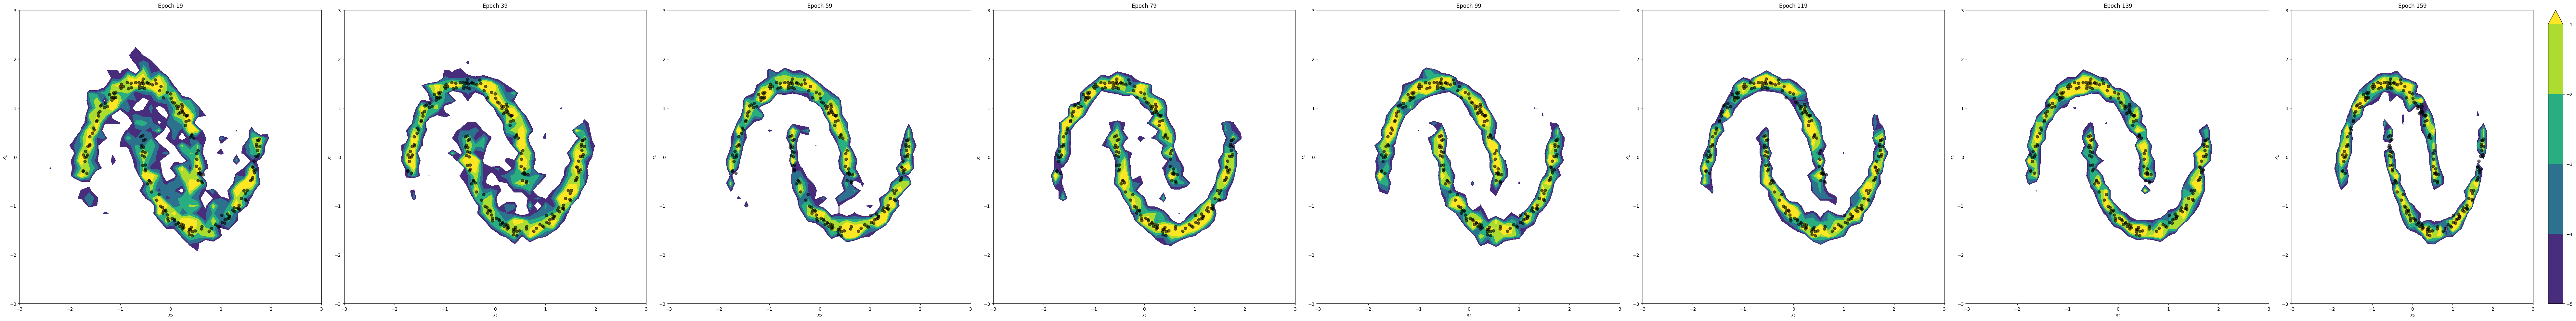

In [22]:
trainer = pl.Trainer(max_epochs=config.num_epochs, enable_checkpointing=True, accelerator=device,
                      default_root_dir=outdir, callbacks=[MyCallback(show=True)])
trainer.fit(model, train_dl, val_dl)

## Plotting and Exploration

In [23]:
model

DiffusionModel(
  (model): MLP(
    (layers): ModuleList(
      (0): Linear(in_features=384, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): ReLU()
      (4): Linear(in_features=128, out_features=2, bias=True)
    )
    (time_mlp): SinusoidalEmbedding()
    (input_mlp1): SinusoidalEmbedding()
    (input_mlp2): SinusoidalEmbedding()
  )
)

In [24]:
# trainer.callbacks

In [25]:
# model.nll_x

In [35]:
c = 3.
x_min, x_max, y_min, y_max, r = -c, c, -c, c, 100
grid_x, grid_y = torch.meshgrid(torch.linspace(x_min, x_max, r), torch.linspace(y_min, y_max, r), indexing='ij')
xs = torch.stack([grid_x.flatten(), grid_y.flatten()]).T
# xs = xs.to(device)

In [41]:
with torch.no_grad():
    nll_grid = - torch.stack([model.nll_x(xs[i]) for i in trange(len(xs))]).reshape((r, r))#.cpu().numpy()

100%|██████████| 10000/10000 [00:18<00:00, 547.75it/s]


In [43]:
nll_grid.shape

torch.Size([100, 100])

In [131]:
# sample, shuffled, from training data
x_sample_training_data = dataset.tensors[0].numpy()

print(len(x_sample_training_data))

random_rows = np.random.choice(len(x_sample_training_data), min(400, len(x_sample_training_data)), replace=False)
x_sample_training_data = x_sample_training_data[random_rows]

print(x_sample_training_data.shape)

8000
(400, 2)


In [142]:
# def plot_flow_samples_2(model, ax, n_pts, batch_size):
#     z = model.base_dist.sample((n_pts,))
#     zk = torch.cat([model(z_)[0] for z_ in z.split(batch_size, dim=0)], 0)
#     zk = zk.cpu().numpy()
#     ax.scatter(zk[:,0], zk[:,1], cmap=plt.cm.jet, alpha=0.5)
#     ax.set_facecolor(plt.cm.jet(0.))
#     ax.set_title('Flow samples')

@torch.no_grad()
def plot_density(model, fig, ax, grid_x, grid_y, log_probs, clim=None):
    cs = ax.pcolormesh(grid_x, grid_y, log_probs, cmap=plt.cm.jet, clim=clim)
    
    cax = fig.add_axes([1.00, 0.10, 0.02, 0.80]) #this locates the axis that is used for your colorbar. It is scaled 0 - 1. 
    fig.colorbar(cs, cax, orientation = 'vertical') #'ax0' tells it which plot to base the colors on
    # cbar = fig.colorbar(cs, ax=ax)

    ax.set_facecolor(plt.cm.jet(0.))
    ax.set_xlim(-c, c)
    ax.set_ylim(-c, c)
    # ax.set_title(title)
    fig.tight_layout()

In [143]:
log_prob = - nll_grid
print(log_prob.shape)

torch.Size([100, 100])


In [144]:
torch.exp(log_prob).shape

torch.Size([100, 100])

<ipython-input-142-e358e637c7a6>:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


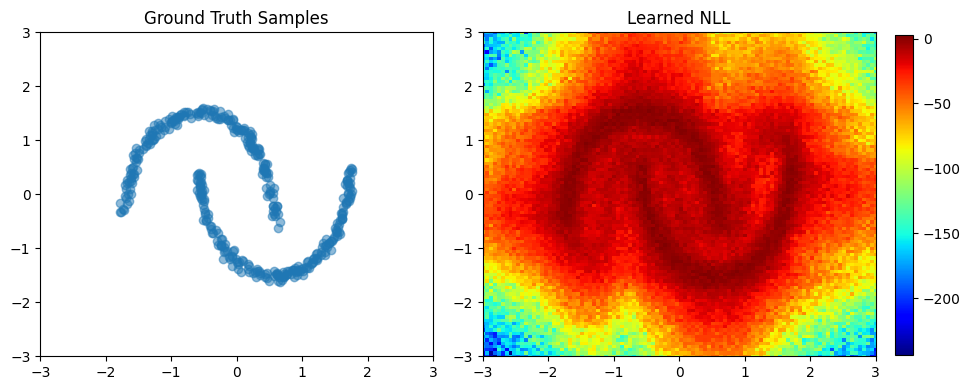

In [148]:
fig, axs = plt.subplots(1, 2, figsize=(9,4)) #, subplot_kw={'aspect': 'equal'})

axs[0].set_title("Ground Truth Samples")
axs[0].scatter(x_sample_training_data[:, 0], x_sample_training_data[:,1], alpha=0.5)
axs[0].set_xlim(-c, c)
axs[0].set_ylim(-c, c)

axs[1].set_title("Learned NLL")
plot_density(model, fig, axs[1], grid_x, grid_y, nll_grid, clim=None)

<ipython-input-142-e358e637c7a6>:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


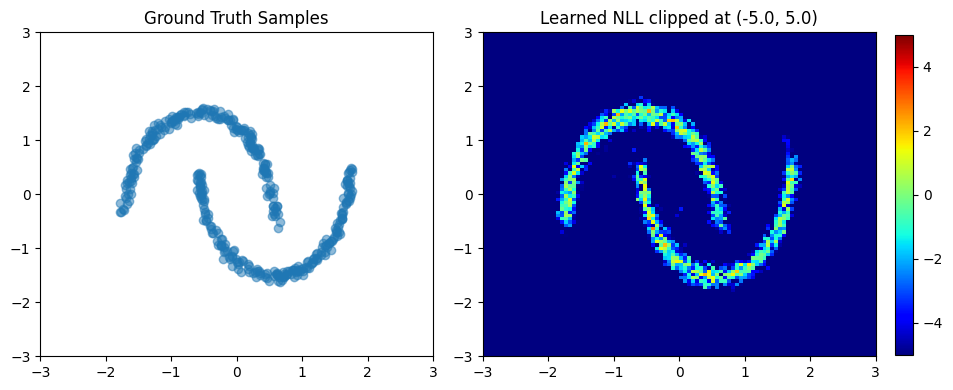

In [150]:
fig, axs = plt.subplots(1, 2, figsize=(9,4)) #, subplot_kw={'aspect': 'equal'})

axs[0].set_title("Ground Truth Samples")
axs[0].scatter(x_sample_training_data[:, 0], x_sample_training_data[:,1], alpha=0.5)
axs[0].set_xlim(-c, c)
axs[0].set_ylim(-c, c)

clim = (-5.0, 5.0)
axs[1].set_title("Learned NLL clipped at {}".format(clim))
plot_density(model, fig, axs[1], grid_x, grid_y, nll_grid, clim=clim)

<ipython-input-142-e358e637c7a6>:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


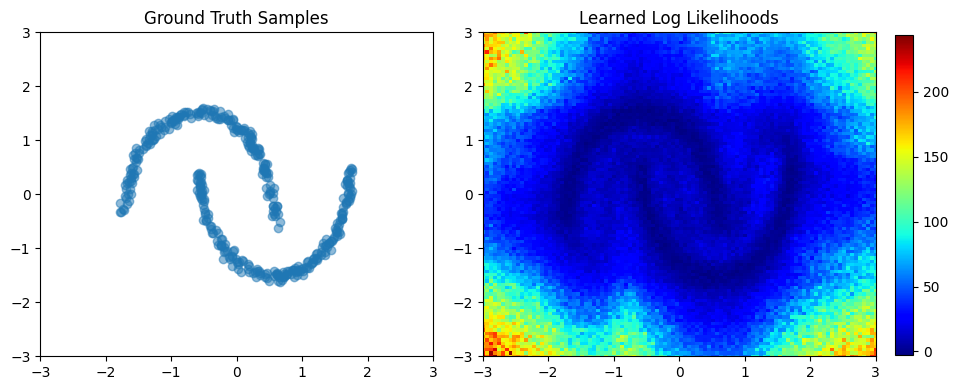

In [154]:
fig, axs = plt.subplots(1, 2, figsize=(9,4)) #, subplot_kw={'aspect': 'equal'})

axs[0].set_title("Ground Truth Samples")
axs[0].scatter(x_sample_training_data[:, 0], x_sample_training_data[:,1], alpha=0.5)
axs[0].set_xlim(-c, c)
axs[0].set_ylim(-c, c)

# clim = (-5.0, 5.0)
axs[1].set_title("Learned Log Likelihoods")
plot_density(model, fig, axs[1], grid_x, grid_y, log_prob, clim=None)

<ipython-input-142-e358e637c7a6>:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


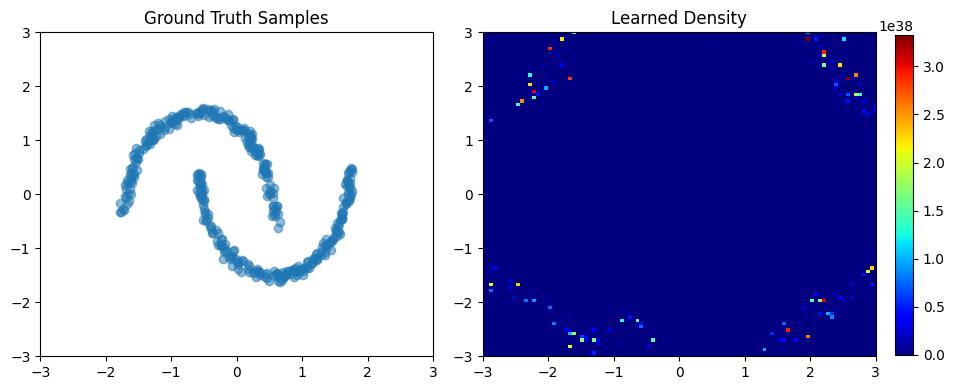

In [157]:
fig, axs = plt.subplots(1, 2, figsize=(9,4)) #, subplot_kw={'aspect': 'equal'})

axs[0].set_title("Ground Truth Samples")
axs[0].scatter(x_sample_training_data[:, 0], x_sample_training_data[:,1], alpha=0.5)
axs[0].set_xlim(-c, c)
axs[0].set_ylim(-c, c)

# clim = (-5.0, 5.0)
axs[1].set_title("Learned Density")
plot_density(model, fig, axs[1], grid_x, grid_y, torch.exp(log_prob), clim=None)

<ipython-input-142-e358e637c7a6>:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/usr/local/lib/python3.9/dist-packages/matplotlib/colors.py:718: RuntimeWarning: overflow encountered in multiply
  xa *= self.N


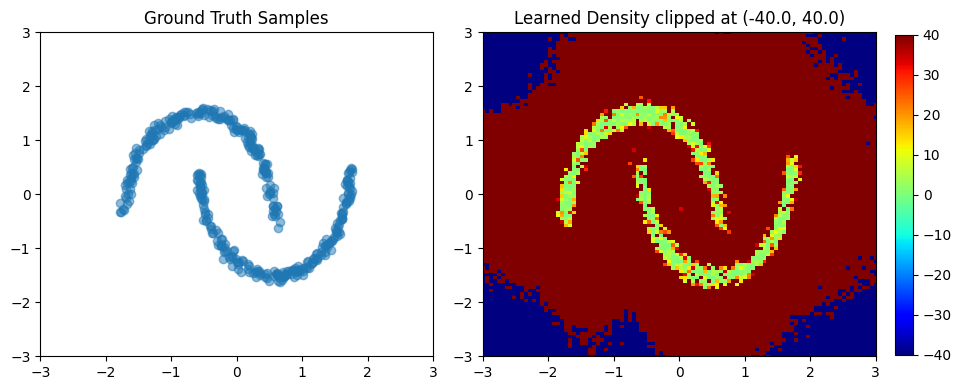

In [189]:
fig, axs = plt.subplots(1, 2, figsize=(9,4)) #, subplot_kw={'aspect': 'equal'})

axs[0].set_title("Ground Truth Samples")
axs[0].scatter(x_sample_training_data[:, 0], x_sample_training_data[:,1], alpha=0.5)
axs[0].set_xlim(-c, c)
axs[0].set_ylim(-c, c)

clim = (-40.0, 40.0)
axs[1].set_title("Learned Density clipped at {}".format(clim))
plot_density(model, fig, axs[1], grid_x, grid_y, torch.exp(log_prob), clim=clim)

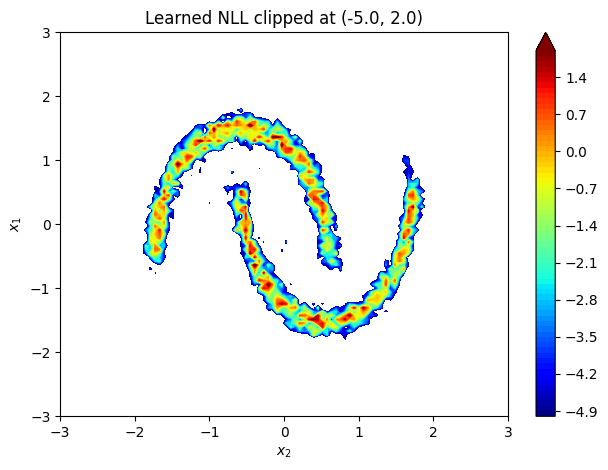

In [196]:
# Contour plots
fig = plt.plot(figsize=(10, 10))
clim = (-5.0, 2.0)
levels = np.arange(clim[0], clim[1] , 0.1) #[-5., -4., -3., -2., -1.]

this_epoch = config.num_epochs

plt.title("Learned NLL clipped at {}".format(clim))
plt.ylabel('$x_1$')
plt.xlabel('$x_2$')
cs = plt.contourf(grid_x, grid_y, nll_grid, levels=levels, extend='max', cmap=plt.cm.jet)
# cs = plt.contourf(grid_x, grid_y, nll_grid, levels=levels, extend='max', cmap=plt.cm.jet)
# cs = plt.contourf(grid_x, grid_y, nll_grid) #, levels=levels, extend='max', cmap=plt.cm.jet)


# plt.set_facecolor(plt.cm.jet(0.))

# plt.scatter(x_sample_training_data[:, 0], x_sample_training_data[:,1], s=40, c='black', alpha=0.6)

cbar = plt.colorbar(cs)
# cbar.plt.set_label(['$-\log p(x)$'])
plt.tight_layout()

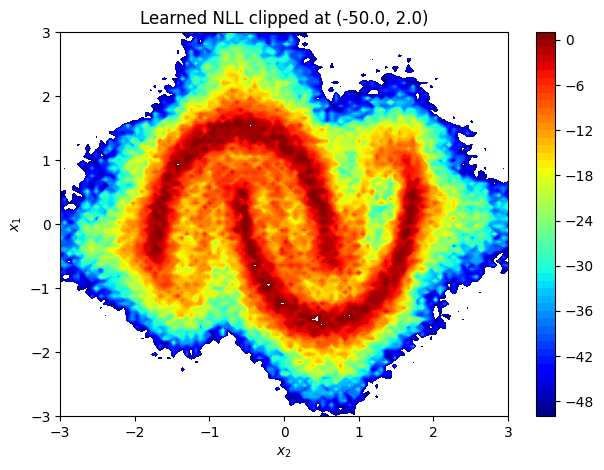

In [195]:
# Contour plots
fig = plt.plot(figsize=(10, 10))
clim = (-50.0, 2.0)
levels = np.arange(clim[0], clim[1] , 1) #[-5., -4., -3., -2., -1.]

this_epoch = config.num_epochs

plt.title("Learned NLL clipped at {}".format(clim))
plt.ylabel('$x_1$')
plt.xlabel('$x_2$')
cs = plt.contourf(grid_x, grid_y, nll_grid, levels=levels, cmap=plt.cm.jet)
# cs = plt.contourf(grid_x, grid_y, nll_grid, levels=levels, extend='max', cmap=plt.cm.jet)
# cs = plt.contourf(grid_x, grid_y, nll_grid) #, levels=levels, extend='max', cmap=plt.cm.jet)


# plt.set_facecolor(plt.cm.jet(0.))

# plt.scatter(x_sample_training_data[:, 0], x_sample_training_data[:,1], s=40, c='black', alpha=0.6)

cbar = plt.colorbar(cs)
# cbar.plt.set_label(['$-\log p(x)$'])
plt.tight_layout()

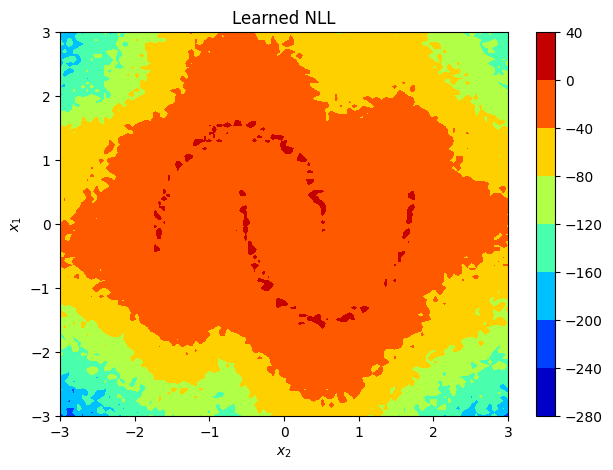

In [193]:
# Contour plots
fig = plt.plot(figsize=(10, 10))

this_epoch = config.num_epochs

plt.title("Learned NLL".format(this_epoch))
plt.ylabel('$x_1$')
plt.xlabel('$x_2$')
cs = plt.contourf(grid_x, grid_y, nll_grid, cmap=plt.cm.jet)
cbar = plt.colorbar(cs)
plt.tight_layout()

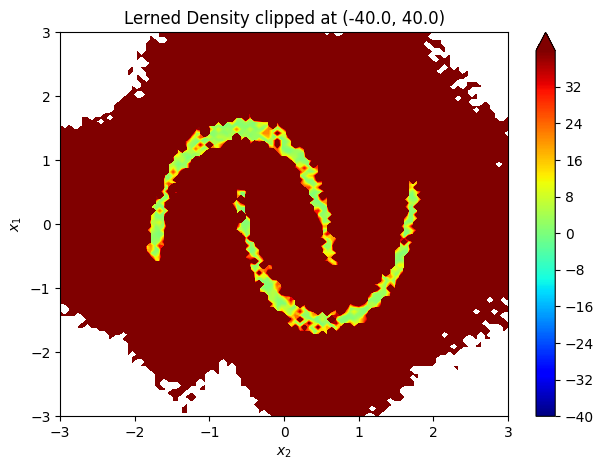

In [192]:
# Contour plots
fig = plt.plot(figsize=(10, 10))
clim = (-40.0, 40.0)
levels = np.arange(clim[0], clim[1] , 0.1) #[-5., -4., -3., -2., -1.]

this_epoch = config.num_epochs

plt.title("Lerned Density clipped at {}".format(clim))
plt.ylabel('$x_1$')
plt.xlabel('$x_2$')
cs = plt.contourf(grid_x, grid_y, torch.exp(log_prob), levels=levels, extend='max', cmap=plt.cm.jet)
# cs = plt.contourf(grid_x, grid_y, nll_grid, levels=levels, extend='max', cmap=plt.cm.jet)
# cs = plt.contourf(grid_x, grid_y, nll_grid) #, levels=levels, extend='max', cmap=plt.cm.jet)


# plt.set_facecolor(plt.cm.jet(0.))

# plt.scatter(x_sample_training_data[:, 0], x_sample_training_data[:,1], s=40, c='black', alpha=0.6)

cbar = plt.colorbar(cs)
# cbar.plt.set_label(['$-\log p(x)$'])
plt.tight_layout()